# Autoregressive Integrated Moving Averages

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

## Augmented Dickey Fuller Test

In [3]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [6]:
# Load datasets
df1 = pd.read_csv('daily-total-female-births.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]  # we only want the first four months
df1

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-04-26,35
1959-04-27,40
1959-04-28,42


In [96]:
df2 = pd.read_csv('TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'
df2

,Inventories
Date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294
...,...
2018-08-01,2127170
2018-09-01,2134172
2018-10-01,2144639


---
# EDA 
---

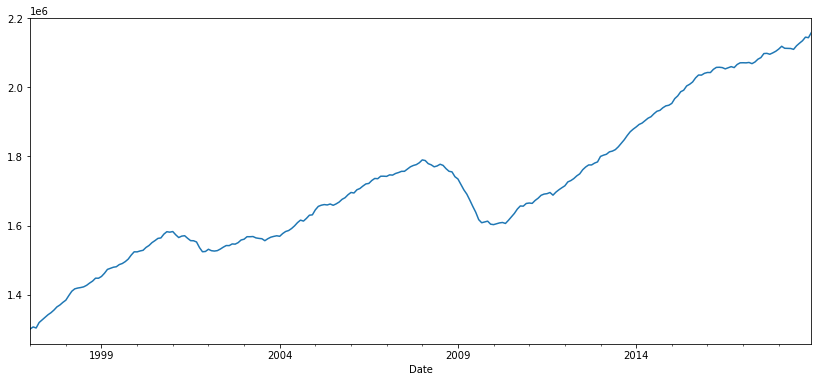

In [98]:
df2['Inventories'].plot(figsize=(14,6))
plt.show()

### Run an ETS Decomposition (optional)

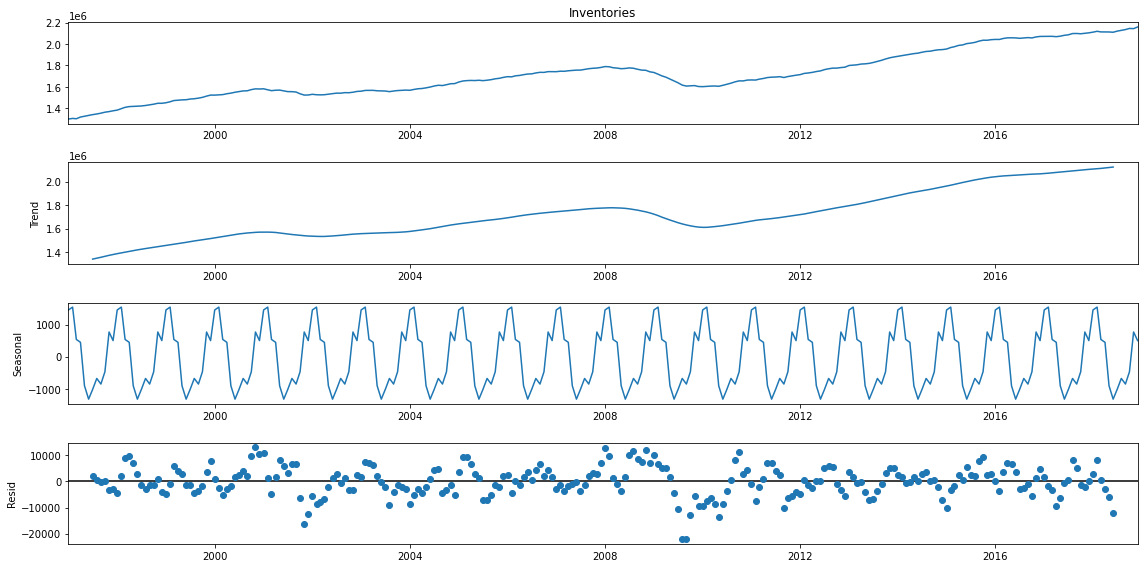

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

with plt.rc_context():
    plt.rc("figure", figsize=(16,8))
    result = seasonal_decompose(df2['Inventories'], model='additive')  # model='add' also works
    result.plot()

### Check stationarity using Dickey-Fuller Test

In [13]:
adf_test(df2['Inventories'])

Fail to reject the null hypothesis
Data is non-stationary


### Do first order differencing - (optional)

In [14]:
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['Inventories'],k_diff=1)
adf_test(df2['d1'])

Reject the null hypothesis
Data is stationary


In [15]:
len(df2)

264

In [93]:
# Set one year for testing
train_data = df2.Inventories[:200]
test_data = df2.Inventories[200:]

In [94]:
print('Train', train_data.shape)

Train (200,)


<AxesSubplot:xlabel='Date'>

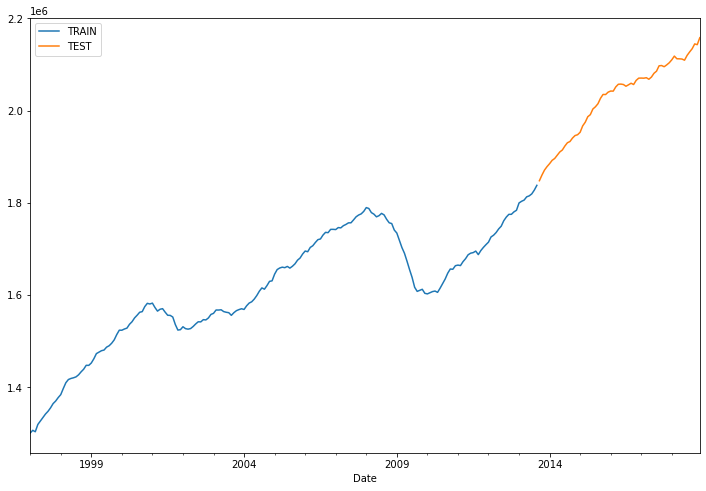

In [95]:
train_data.plot(legend=True,label='TRAIN')
test_data.plot(legend=True,label='TEST',figsize=(12,8))

### ARIMA Hyperparameter Tuning

In [61]:
# grid search ARIMA parameters for a time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [62]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [184]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
evaluate_models(df2.Inventories.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=189211.882
ARIMA(0, 0, 1) RMSE=96626.756
ARIMA(0, 0, 2) RMSE=56732.100
ARIMA(0, 0, 3) RMSE=36544.296
ARIMA(0, 0, 4) RMSE=28678.846
ARIMA(0, 1, 0) RMSE=5034.659
ARIMA(0, 1, 1) RMSE=5018.624
ARIMA(0, 1, 2) RMSE=5021.567
ARIMA(0, 1, 3) RMSE=4991.656
ARIMA(0, 1, 4) RMSE=4982.738
ARIMA(0, 2, 0) RMSE=5239.043
ARIMA(0, 2, 1) RMSE=5253.131
ARIMA(0, 2, 2) RMSE=5210.447
ARIMA(0, 2, 3) RMSE=5219.412
ARIMA(0, 2, 4) RMSE=5216.567
ARIMA(0, 3, 0) RMSE=8678.801
ARIMA(0, 3, 1) RMSE=5252.637
ARIMA(0, 3, 2) RMSE=8454.727
ARIMA(0, 3, 3) RMSE=7946.027
ARIMA(0, 3, 4) RMSE=5022.996
ARIMA(0, 4, 0) RMSE=15737.375
ARIMA(0, 4, 1) RMSE=16180.158
ARIMA(0, 4, 2) RMSE=8028.450
ARIMA(0, 4, 3) RMSE=7689.776
ARIMA(0, 4, 4) RMSE=7399.766
ARIMA(1, 0, 0) RMSE=5084.354
ARIMA(1, 0, 1) RMSE=4707.966
ARIMA(1, 0, 2) RMSE=4674.352
ARIMA(1, 0, 3) RMSE=4396.971
ARIMA(1, 0, 4) RMSE=4493.566
ARIMA(1, 1, 0) RMSE=5018.367
ARIMA(1, 1, 1) RMSE=4411.359
ARIMA(1, 1, 2) RMSE=4451.254
ARIMA(1, 1, 3) RMSE=4524.692
ARIMA(

### Build Model based on the optimized values

In [185]:
from statsmodels.tsa.arima.model import ARIMA

In [186]:
model = ARIMA(train_data,order=(3, 0, 4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Inventories   No. Observations:                  200
Model:                 ARIMA(3, 0, 4)   Log Likelihood               -1987.318
Date:                Wed, 13 Jul 2022   AIC                           3992.636
Time:                        16:08:51   BIC                           4022.321
Sample:                    01-01-1997   HQIC                          4004.649
                         - 08-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.615e+06   1.83e-08   8.83e+13      0.000    1.61e+06    1.61e+06
ar.L1          1.0856      0.078     13.941      0.000       0.933       1.238
ar.L2          0.7163      0.123      5.834      0.000       0.476       0.957
ar.L3         -0.8032      0.062    -12.863      0.000      -0.926      -0.681
ma.L1          0.4042      0.153      2.642      0.008       0.104       0.704
ma.L2         -0.6254      0.113     -5.544      0.000      -0.847      -0.404
ma.L3         -0.0141      0.096     -0.147      0.883      -0.201       0.173
ma.L4          0.0157      0.098      0.159      0.873      -0.177       0.209
sigma2      2.488e+07   7.85e-09   3.17e+15      0.000    2.49e+07    2.49e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.78   Prob(JB):                         0.89
Heteroskedasticity (H):               1.29   Skew:                             0.06
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.87e+30. Standard errors may be unstable.
"""

### Use model to predict

In [187]:
# Obtain predicted values
start=len(train_data)
end=len(df2)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')
predictions = predictions.rename('ARIMA(3,0,4) Predictions')

In [151]:
len(train_data)-len(df2)

-64

In [152]:
len(train_data)

200

In [153]:
len(df2)

264

In [154]:
len(test_data)

64

In [155]:
len(predictions)

64

In [188]:
test_data

Date
2013-09-01    1848087
2013-10-01    1860310
2013-11-01    1871121
2013-12-01    1878653
2014-01-01    1885013
               ...   
2018-08-01    2127170
2018-09-01    2134172
2018-10-01    2144639
2018-11-01    2143001
2018-12-01    2158115
Freq: MS, Name: Inventories, Length: 64, dtype: int64

In [189]:
predictions

2013-09-01    1.843791e+06
2013-10-01    1.849337e+06
2013-11-01    1.854112e+06
2013-12-01    1.858722e+06
2014-01-01    1.862619e+06
                  ...     
2018-08-01    1.799069e+06
2018-09-01    1.796559e+06
2018-10-01    1.794061e+06
2018-11-01    1.791579e+06
2018-12-01    1.789112e+06
Freq: MS, Name: ARIMA(3,0,4) Predictions, Length: 64, dtype: float64

In [191]:
# Compare predictions to expected values
for i in range(len(test_data)):
    print(f"predicted={predictions[i]:<.10}, expected={test_data[i]}")

predicted=1843790.835, expected=1848087
predicted=1849336.865, expected=1860310
predicted=1854111.88, expected=1871121
predicted=1858721.57, expected=1878653
predicted=1862618.851, expected=1885013
predicted=1866315.983, expected=1892254
predicted=1869418.354, expected=1896241
predicted=1872303.939, expected=1903303
predicted=1874688.939, expected=1910340
predicted=1876852.975, expected=1914620
predicted=1878592.71, expected=1923259
predicted=1880115.653, expected=1930392
predicted=1881276.822, expected=1933021
predicted=1882230.789, expected=1940519
predicted=1882874.831, expected=1945946
predicted=1883324.601, expected=1947774
predicted=1883507.915, expected=1953109
predicted=1883511.763, expected=1966936
predicted=1883285.976, expected=1974832
predicted=1882896.385, expected=1986781
predicted=1882308.645, expected=1991247
predicted=1881572.921, expected=2003489
predicted=1880666.193, expected=2008314
predicted=1879626.991, expected=2014926
predicted=1878440.36, expected=2026759
pred

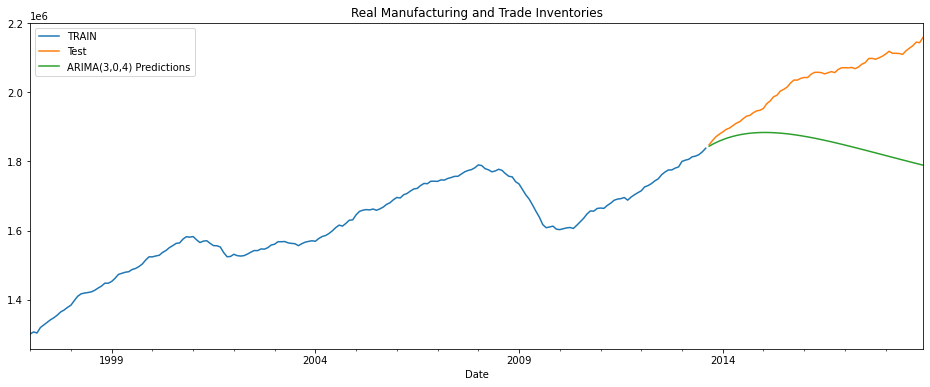

In [192]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Inventories'
xlabel='' 

train_data.plot(legend=True,label='TRAIN' ,figsize=(16,6),title=title)
test_data.plot(legend=True,label='Test',figsize=(16,6),title=title)
predictions.plot(legend=True)
plt.show()

<AxesSubplot:xlabel='Date'>

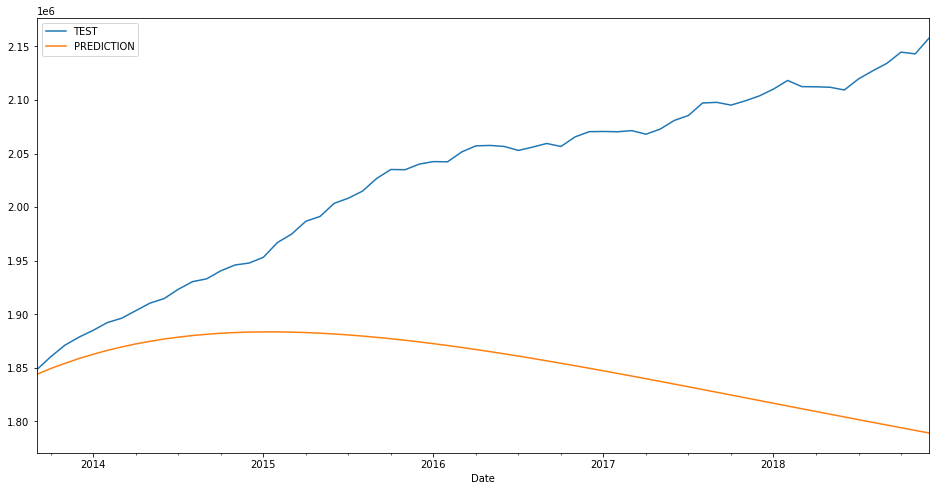

In [193]:
#train_data['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_data.plot(legend=True,label='TEST',figsize=(16,8))
predictions.plot(legend=True,label='PREDICTION',xlim=['2013-09-01','2018-12-01'])

### Evaluate the Model

In [194]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_data, predictions)
error.round(2)

41951060391.44

In [195]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test_data, predictions)
error.round(2)

204819.58

### Retrain the model on the full data, and forecast the future

In [196]:
model = ARIMA(df2['Inventories'],order=(3,0,4))
results = model.fit()
fcast = results.predict(len(df2),len(df2)+11,typ='levels').rename('ARIMA(3,0,4) Forecast')

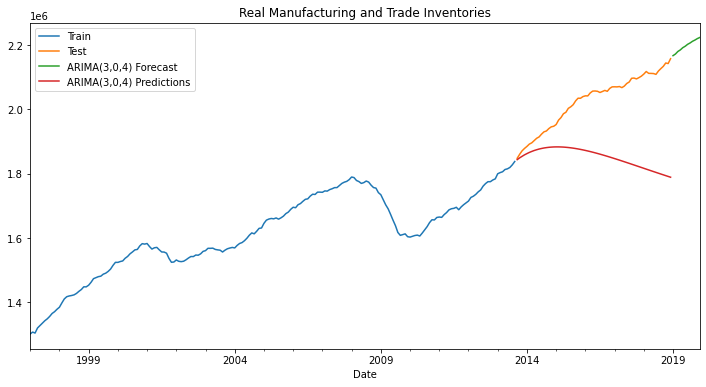

In [197]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Inventories'
xlabel='Period' 

train_data.plot(legend=True,label='Train',figsize=(12,6),title=title)
test_data.plot(legend=True,label='Test',figsize=(12,6),title=title)
fcast.plot(legend=True)
predictions.plot(legend=True)
plt.show()